In [0]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from PIL import Image
import tensorflow as tf

In [2]:
!pip install tqdm
from tqdm import tqdm
tf.set_random_seed(10)
np.random.seed(10)

In [3]:
MNIST_DATASETS = tf.contrib.learn.datasets.load_dataset("mnist")

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
STARTER_LR = 1e-4
BATCH_SIZE = 100
NUM_CLASSES = 10
MAX_STEPS = 3
IMAGE_SIZE = 28
OUTPUT_NAMES = ['fc2/add']

In [0]:
def WeightsVariable(shape, name = 'weights'):
    return tf.Variable(tf.truncated_normal(shape, mean = 0.0, stddev=0.01, name=name))

def BiasVariable(shape, name = 'biases'):
    return tf.Variable(tf.constant(0.1, shape=[shape], name='biases'))

def Conv2d(x, W, B, stride = 1, padding = 'VALID', activation_fun = True):
    filter_size = W.get_shape().as_list()
    pad_size = filter_size[0] // 2
    pad_mat = np.array([[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]])
    
    x = tf.pad(x, pad_mat)
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding = padding)
    x = tf.nn.bias_add(x, B)
    
    if(activation_fun == True):
        return tf.nn.relu(x)
    else:
        return x

def MaxPool2d(x, k = 2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'VALID')

In [0]:
def network(images, channels = 1):
    num_c = [8, 16, 32, 64, 64, 128]
    #COONVOLUTION 1
    with tf.name_scope('Conv1'):
        weights = WeightsVariable([3, 3, channels, num_c[0]])
        bias = BiasVariable(num_c[0])
        conv1 = Conv2d(images, weights, bias)
        
    with tf.name_scope('Conv2_m'):
        weights = WeightsVariable([3, 3, num_c[0], num_c[1]])
        bias = BiasVariable(num_c[1])
        conv2 = Conv2d(conv1, weights, bias)
        pool1 = MaxPool2d(conv2)
        
    with tf.name_scope('Conv3'):
        weights = WeightsVariable([3, 3, num_c[1], num_c[2]])
        bias = BiasVariable(num_c[2])
        conv3 = Conv2d(pool1, weights, bias)
    
    with tf.name_scope('Conv4_m'):
        weights = WeightsVariable([3, 3, num_c[2], num_c[3]])
        bias = BiasVariable(num_c[3])
        conv4 = Conv2d(conv3, weights, bias)
        pool2 = MaxPool2d(conv4)
    
    with tf.name_scope('flatten'):
        flat = tf.layers.flatten(pool2)
    
    input_flat_shape = np.int32(flat.shape[1])
    
    with tf.name_scope('fc1'):
        weights = WeightsVariable([input_flat_shape, 64])
        biases = BiasVariable(64)
        fc1 = tf.nn.relu(tf.matmul(flat, weights) + biases)

    with tf.name_scope('fc2'):
        weights = WeightsVariable([64, 10])
        biases = BiasVariable(10)
        fc2 = tf.matmul(fc1, weights) + biases
    return fc2

In [0]:
def loss_metrics(logits, labels):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
    return tf.reduce_mean(cross_entropy, name = 'softmax_mean')

In [0]:
#returns the optimizer by taking the loss
def training(loss):
    tf.summary.scalar('loss', loss)
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    learning_rate = tf.train.exponential_decay(STARTER_LR, 
                                               global_step = global_step, 
                                               decay_steps = 1000, 
                                               decay_rate = 0.7, 
                                               staircase = True)

    tf.summary.scalar('learning_rate', learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)
    train_op = optimizer.minimize(loss)
    return train_op
    

In [0]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, k = 1)

    return tf.reduce_sum(tf.cast(correct, tf.int32))#, accuracy1, accuracy2
  
def acc(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1), name='correct_pred')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

In [0]:
def do_eval(sess, eval_correct, image_placeholder, labels_placeholder, data_set, summary):
    true_count = 0
    steps_per_epoch = data_set.num_examples // BATCH_SIZE
    
    num_examples = steps_per_epoch * BATCH_SIZE
    
    for steps in range(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set, image_placeholder, labels_placeholder)
        log, correctness = sess.run([eval_correct], feed_dict = feed_dict)
        true_count += correctness
    
    precision = float(true_count) / num_examples
#     tf.summary.scalar('Precision', tf.constant(precision))
    print('Num examples %d, Num Correct: %d Precisiokn @ 1: %0.04f' %
          (num_examples, true_count, precision))
    
    return log

In [0]:
def placeholder_inputs(batch_size, shape = [28, 28, 1]):
    image_placeholder = tf.placeholder(tf.float32, shape = (None, shape[0], shape[1], shape[2]))
    label_placeholder = tf.placeholder(tf.int32, shape = (None))
    return image_placeholder, label_placeholder

In [0]:
def fill_feed_dict(data_set, image_placeholder, label_placeholder):
    images_feed, labels_feed = data_set.next_batch(BATCH_SIZE)
    feed_dict = {
        image_placeholder: np.reshape(images_feed, (-1, 28, 28, 1)),
        label_placeholder: labels_feed
                }
    return feed_dict

In [0]:

loss_plot = []
acc_plot = []
def run_training(Dataset):
    with tf.Graph().as_default():

        images_pl, labels_pl = placeholder_inputs(BATCH_SIZE)
        logits = network(images_pl)
        loss = loss_metrics(logits = logits, labels = labels_pl)
        train_op = training(loss)
        eval_correct = evaluation(logits, labels_pl)
        acc_val = acc(logits, labels_pl)
        summary = tf.summary.merge_all()
        
        init = tf.global_variables_initializer()
        
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) #OPTIONAL
        sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))
        
        summary_writer = tf.summary.FileWriter("/tmp/tf/eg/log", 
                                               graph = tf.get_default_graph())
        test_writer = tf.summary.FileWriter("tmp/tf/eg/validation/log", 
                                            graph = tf.get_default_graph())
        saver = tf.train.Saver()
        sess.run(init)
        for steps in range(MAX_STEPS):
            start_time = time.time()

            for i in tqdm(np.arange(0, Dataset.train.num_examples, BATCH_SIZE)):
                images_feed, labels_feed = Dataset.train.next_batch(BATCH_SIZE)

                feed_dict = {
                    images_pl: np.reshape(images_feed, (-1, 28, 28, 1)),
                    labels_pl: labels_feed
                            }

                _ = sess.run([train_op], feed_dict = feed_dict)
                duration = time.time() - start_time

#                 if (steps%100 == 0):
#                     print('Step %d: loss = %.2f (%.3f sec)' % (steps, loss_value, duration))
#                     summary_str = sess.run(summary, feed_dict = feed_dict)
#                     summary_writer.add_summary(summary_str, steps)
#                     summary_writer.flush()

#                 if (steps + 1) % 1000 == 0 or (steps + 1) == MAX_STEPS:
#                     checkpoint_file = os.path.join("model", "model.ckpt")
#                     saver.save(sess, checkpoint_file, global_step=steps)
#                     print('Validation Data Eval:')
#                     log = do_eval(sess,
#                                   eval_correct,
#                                   images_pl,
#                                   labels_pl,
#                                   Dataset.validation,
#                                   summary)
#                     test_writer.add_summary(log, steps)

            images_feed, labels_feed = Dataset.validation.images, Dataset.validation.labels

            feed_dict = {
                images_pl: np.reshape(images_feed, (-1, 28, 28, 1)),
                labels_pl: labels_feed
                        }
            accuracy, loss  = sess.run([eval_correct, loss], feed_dict = feed_dict)
            
            loss_plot.append(loss)
            acc_plot.append(accuracy)
            print('\t Loss %d: loss = %.2f\t' % (steps+1, loss))     
          
        graphdef = tf.get_default_graph().as_graph_def()

        frozen_graph = tf.graph_util.convert_variables_to_constants(sess,
                                                                    graphdef,
                                                                    OUTPUT_NAMES)
        return tf.graph_util.remove_training_nodes(frozen_graph),sess, images_pl, labels_pl, eval_correct, logits

In [72]:
MAX_STEPS = 5
loss_plot = []
tf_model, sess, images_pl, labels_pl, eval_correct, logits = run_training(MNIST_DATASETS)

  2%|▏         | 13/550 [00:00<00:04, 120.45it/s]

	 Loss 1: loss = 2.29	


100%|██████████| 550/550 [00:04<00:00, 117.28it/s]


TypeError: ignored

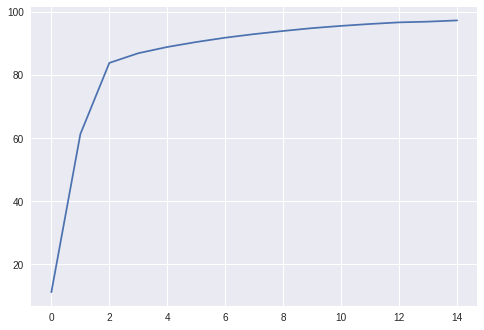

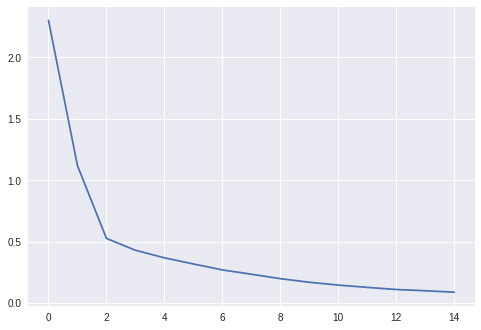

In [59]:
sns.set_style("darkgrid")
plt.plot(acc_plot)
plt.show()
plt.plot(loss_plot)

In [60]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1)),labels_pl: labels_feed
            }
with sess.as_default():
  accuracy  = sess.run([eval_correct], feed_dict = feed_dict)
  print(accuracy)

[4860]


In [62]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1))
            }
with sess.as_default():
  accuracy  = sess.run([logits], feed_dict = feed_dict)
  
  preds = np.argmax(accuracy[0], 1)
  print(preds)

[5 0 4 ... 2 1 2]


In [63]:
from sklearn.metrics import classification_report
print(classification_report(labels_feed, preds))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       479
          1       0.97      0.98      0.97       563
          2       0.98      0.93      0.96       488
          3       0.98      0.96      0.97       493
          4       0.98      0.98      0.98       535
          5       0.96      0.98      0.97       434
          6       0.98      0.98      0.98       501
          7       0.96      0.97      0.97       550
          8       0.96      0.97      0.97       462
          9       0.96      0.96      0.96       495

avg / total       0.97      0.97      0.97      5000



In [64]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_feed, preds))

[[473   0   0   0   0   2   2   0   0   2]
 [  0 553   2   2   1   0   1   2   2   0]
 [  1  10 454   5   1   1   0   7   8   1]
 [  0   1   2 475   0   7   0   5   2   1]
 [  0   1   0   0 526   0   4   1   0   3]
 [  0   1   1   0   1 427   0   0   3   1]
 [  3   2   0   0   1   1 493   0   1   0]
 [  0   2   2   1   3   0   0 536   0   6]
 [  0   2   0   1   0   3   1   2 449   4]
 [  2   1   0   2   5   2   0   7   2 474]]


In [0]:
# graph = tf.GraphDef()
# graph.ParseFromString(tf_model.SerializeToString())

# with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#     tf.import_graph_def(graph, name="prefix")
    
    